In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
base_csv = 'IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Separando em treino e teste

In [5]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape de treino {x_train.shape}')
print(f'shape de teste {x_test.shape}')

shape de treino (37500,)
shape de teste (12500,)


### Distribuição das labels

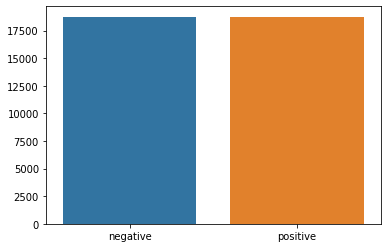

In [6]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tokenização

In [7]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    wordCount = Counter(word_list)
    wordCount = sorted(wordCount,key=wordCount.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(wordCount)}

    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\orlan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

<ipython-input-7-ba2200c50cfd>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


### Transformar os textos em um tamanho fixo 

In [9]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [10]:
# Tamanho máximo dos textos é de 500 palavras
x_train_pad = padding(x_train,500)
x_test_pad = padding(x_test,500)


### Criando Dataset para o treinamento

In [11]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [12]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 409, 456, 307],
        [  0,   0,   0,  ...,  43, 166, 461],
        [  0,   0,   0,  ..., 231,   6, 163],
        ...,
        [  0,   0,   0,  ..., 337, 251,   3],
        [  0,   0,   0,  ..., 724, 983, 206],
        [  0,   0,   0,  ...,   1,   1, 148]], dtype=torch.int32)
Sample input: 
 tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1], dtype=torch.int32)


### Criação do modelo

In [13]:
class LSTM(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(LSTM,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        self.dropout = nn.Dropout(0.3)
    
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        out, hidden = self.lstm(embeds, hidden)
        out = out.contiguous().view(-1, self.hidden_dim) 
        
        out = self.dropout(out)
        out = self.fc(out)
        
        out = self.sig(out)
        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out, hidden
        
        
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [14]:
def criarModelo():    
    no_layers = 2
    vocab_size = len(vocab) + 1
    embedding_dim = 64
    output_dim = 1
    hidden_dim = 256


    model = LSTM(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5)
    model.to(device)
    return model

model = criarModelo()


### Training

In [23]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [24]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        # Se tivemos melhora em relação a ultima execução salvamos o resultado
        torch.save(model.state_dict(), 'modelo.weights')
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.6834662895202637 val_loss : 0.6863965966701507
train_accuracy : 53.504 val_accuracy : 56.855999999999995
Epoch 2
train_loss : 0.5218110496401787 val_loss : 0.4033864519000053
train_accuracy : 73.952 val_accuracy : 81.88
Epoch 3
train_loss : 0.36795173393686614 val_loss : 0.33694441425800326
train_accuracy : 83.93866666666666 val_accuracy : 85.49600000000001
Epoch 4
train_loss : 0.32780184586842853 val_loss : 0.3202640498280525
train_accuracy : 85.936 val_accuracy : 86.24000000000001
Epoch 5
train_loss : 0.30246707102656367 val_loss : 0.3169309302866459
train_accuracy : 87.0 val_accuracy : 86.768


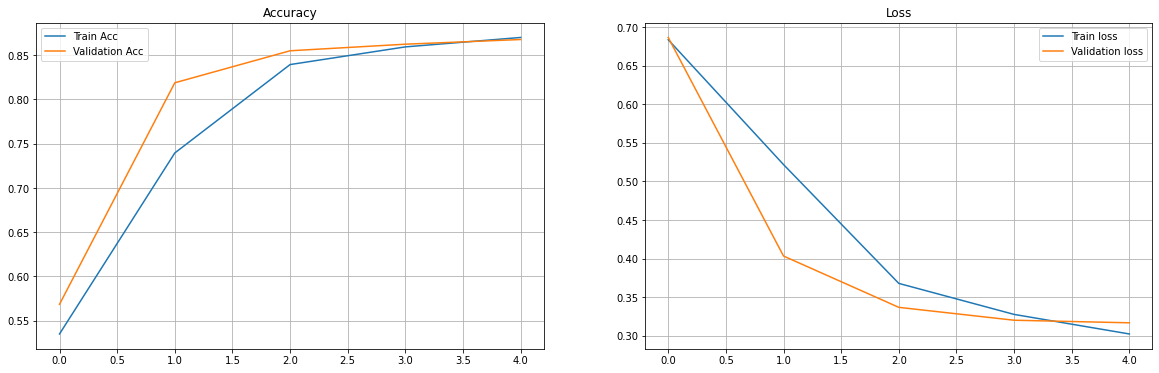

In [25]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Predição

In [26]:
modeloPredict = criarModelo()
modeloPredict.load_state_dict(torch.load("modelo.weights"))
modeloPredict.eval()


LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [27]:
def predict(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = modeloPredict.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = modeloPredict(inputs, h)
        return 1 if output.item() > 0.5 else 0

In [31]:
# Exemplo de teste
index = 39
print(df['review'][index])
print('='*70)
print(f'Sentimento no dataset : {df["sentiment"][index]}')
print('='*70)
pro = predict(df['review'][index])
status = "positive" if pro == 1 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Sentimento previsto "{status}"')

After sitting through this pile of dung, my husband and I wondered whether it was actually the product of an experiment to see whether a computer program could produce a movie. It was that listless and formulaic. But the U.S. propaganda thrown in your face throughout the film proves--disappointingly--that it's the work of humans. Call me a conspiracy theorist, but quotes like, "We have to steal the Declaration of Independence to protect it" seem like ways to justify actions like the invasion of Iraq, etc. The fact that Nicholas Cage spews lines like, "I would never use the Declaration of Independence as a bargaining chip" with a straight face made me and my husband wonder whether the entire cast took Valium before shooting each scene. The "reasoning" behind each plot turn and new "clue" is truly ridiculous and impossible to follow. And there's also a bonus side plot of misogyny, with Dr. Whatever-Her-Name-Was being chided by all involved for "never shutting up." She's clearly in the mo